# AM data analysis

#### Description of data and aims:
In the summer of 2024, a mysterious disease dubbed the “pundemic” by the media began cropping up worldwide. Diseased patients make puns at every opportunity. A link between the pundemic and changes in the gut microbiome was discovered, and a doctor at the USZ set up a clinical trial using fecal microbiota transplants (FMT) as a possible treatment.

Trial data:  
Collection of fecal microbiome samples from pundemic patients before and after the trial, from both treatment and placebo groups. Pundemic severity in patients was quantified in terms of puns per hour. Fecal samples were collected from the FMT donors as well.

Because the bacterial and fungal gut microbiome are both of interest, the USZ team collected both **16S rRNA gene** and **ITS** data from the study cohort. 

Aims:
1. Analyzing the ITS data in order to further explore the connection between pundemic symptoms and an altered gut mycobiome composition
2. Analyzing the potential of FMT as a pandemic treatment option. You have received DNA sequences as well as metadata allowing you to distinguish pundemic from healthy samples.


In [1]:
# Package import
import os
import pandas as pd
from qiime2 import Visualization
import matplotlib.pyplot as plt
import numpy as np
import qiime2 as q2

%matplotlib inline

In [30]:
data_dir = 'data/raw'
data_dir_p = 'data/processed'

## Data import and denoising

In [5]:
# Data and metadata import
#! wget -O data/raw/pundemic_metadata.tsv https://polybox.ethz.ch/index.php/s/7LxWSbaw2q37yof/download
#! wget -O data/raw/pundemic_forward_reads.qza https://polybox.ethz.ch/index.php/s/o8HqHJqvuf9e2on/download


--2024-10-03 22:55:02--  https://polybox.ethz.ch/index.php/s/7LxWSbaw2q37yof/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10868 (11K) [application/octet-stream]
Saving to: ‘data/raw/pundemic_metadata.tsv’

data/raw/pundemic_m 100%[===================>]  10.61K  --.-KB/s    in 0s      

2024-10-03 22:55:02 (106 MB/s) - ‘data/raw/pundemic_metadata.tsv’ saved [10868/10868]

--2024-10-03 22:55:02--  https://polybox.ethz.ch/index.php/s/o8HqHJqvuf9e2on/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 942144925 (898M) [application/octet-stream]
Saving to: ‘data/raw/pundemic_forward_reads.qza’

data/raw/pundemic_f 100%[===================>] 898.50M   314MB/s    in 2.9s    

202

In [2]:
# Metadata df creation and overview
meta_df = pd.read_csv('data/raw/pundemic_metadata.tsv', sep='\t', index_col=0)
meta_df

,patient_id,age,sex,ethnicity,continent,country,region,city,group,disease_subgroup,blinded_clinical_response,puns_per_hour_pre_treatment,puns_per_hour_post_treatment,time_point
id,,,,,,,,,,,,,,
SRR10505051,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,post-treatment
SRR10505052,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,pre-treatment
SRR10505053,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,pre-treatment
SRR10505054,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,post-treatment
SRR10505055,1044,34,male,Indian Subcontinental,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NaN,4.0,NaN,pre-treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR10505151,D54,Unknown,Unknown,NaN,Europe,Switzerland,Zurich,Zurich,Healthy,donor,NaN,NaN,NaN,t1
SRR10505152,D53,Unknown,Unknown,NaN,Europe,Switzerland,Zurich,Zurich,Healthy,donor,NaN,NaN,NaN,t1
SRR10505153,2225,34,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,NR,6.0,5.0,pre-treatment


In [3]:
meta_df.head()

,patient_id,age,sex,ethnicity,continent,country,region,city,group,disease_subgroup,blinded_clinical_response,puns_per_hour_pre_treatment,puns_per_hour_post_treatment,time_point
id,,,,,,,,,,,,,,
SRR10505051,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,post-treatment
SRR10505052,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,pre-treatment
SRR10505053,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,pre-treatment
SRR10505054,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,post-treatment
SRR10505055,1044,34,male,Indian Subcontinental,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NaN,4.0,NaN,pre-treatment


In [4]:
meta_df['disease_subgroup'].unique()

array(['Placebo', 'FMT', 'donor'], dtype=object)

In [19]:
patient_df = meta_df[(meta_df['disease_subgroup'] == "placebo") | (meta_df['disease_subgroup'] == "FMT")]
patient_df.to_csv('data/raw/patient_df', sep = '\t')

In [20]:
donor_df = meta_df[(meta_df['disease_subgroup'] == "donor")]
donor_df.to_csv('data/raw/donor_df', sep = '\t')

In [25]:
meta_df[(meta_df['time_point'] == "pre-treatment") | (meta_df['time_point'] == "post-treatment")]

,patient_id,age,sex,ethnicity,continent,country,region,city,group,disease_subgroup,blinded_clinical_response,puns_per_hour_pre_treatment,puns_per_hour_post_treatment,time_point
id,,,,,,,,,,,,,,
SRR10505051,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,post-treatment
SRR10505052,1048,36,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NR,9.0,8.0,pre-treatment
SRR10505053,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,pre-treatment
SRR10505054,1045,29,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,Res,6.0,0.0,post-treatment
SRR10505055,1044,34,male,Indian Subcontinental,Europe,Switzerland,Zurich,Zurich,Puns,Placebo,NaN,4.0,NaN,pre-treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR10505141,1001,57,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,Res,7.0,2.0,pre-treatment
SRR10505142,1001,57,female,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,Res,7.0,2.0,post-treatment
SRR10505153,2225,34,male,Caucasian,Europe,Switzerland,Zurich,Zurich,Puns,FMT,NR,6.0,5.0,pre-treatment


We have 105 samples

### Plots exploring data

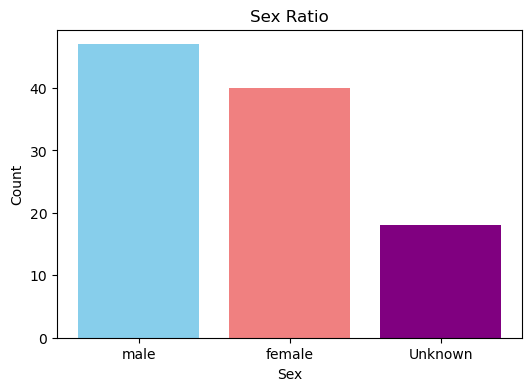

In [10]:
sex_counts = meta_df['sex'].value_counts()

# Create a barplot
plt.figure(figsize=(6, 4))
plt.bar(sex_counts.index, sex_counts.values, color=['skyblue', 'lightcoral', 'purple'])
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex Ratio')
plt.show()

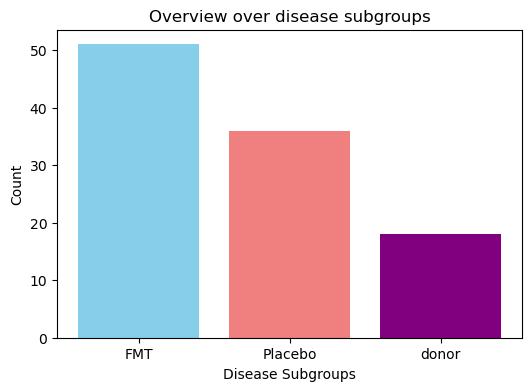

In [13]:
disease_counts = meta_df['disease_subgroup'].value_counts()

# Create a barplot
plt.figure(figsize=(6, 4))
plt.bar(disease_counts.index, disease_counts.values, color=['skyblue', 'lightcoral', 'purple'])
plt.xlabel('Disease Subgroups')
plt.ylabel('Count')
plt.title('Overview over disease subgroups')
plt.show()

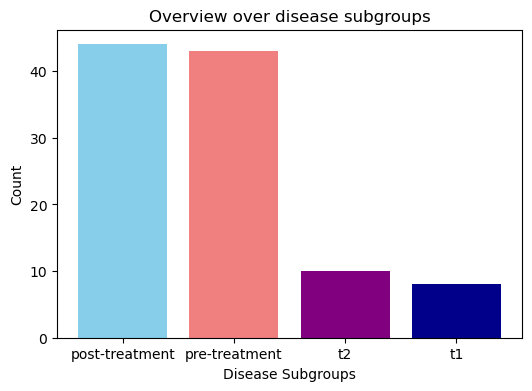

In [15]:
time_counts = meta_df['time_point'].value_counts()

# Create a barplot
plt.figure(figsize=(6, 4))
plt.bar(time_counts.index, time_counts.values, color=['skyblue', 'lightcoral', 'purple', 'darkblue'])
plt.xlabel('Timepoints')
plt.ylabel('Count')
plt.title('Overview over timepoints')
plt.show()

## Sequence Import

In [22]:
! qiime tools peek $data_dir/pundemic_forward_reads.qza

UUID:        15b104e4-bd22-4469-92ac-e08f76767733
Type:        SampleData[SequencesWithQuality]
Data format: SingleLanePerSampleSingleEndFastqDirFmt


In [25]:
! qiime demux summarize \
    --i-data $data_dir/pundemic_forward_reads.qza \
    --o-visualization $data_dir/pundemic_forward_reads.qzv

Saved Visualization to: data/raw/pundemic_forward_reads.qzv


In [26]:
Visualization.load(f"{data_dir}/pundemic_forward_reads.qzv")

<visualization: Visualization uuid: 84dda303-0886-4a9f-9f5e-bf58b7fdcd3e>

## Denoising
Our sequences originate from the ITS-1 region and were sequenced on an Illumina MiSeq machine. The sequence files contain demultiplexed single-end sequences.

For denoising we are trimming the data after 129 nucleotides (at 130 first time 25 per centile quality score dropped below 20). We're doing this using DADA2. It also removes chimeras. The output of applying DADA gives us features which are representative sequences for organisms.

In [27]:
! qiime dada2 denoise-single \
    --i-demultiplexed-seqs $data_dir_p/pundemic_forward_reads.qza \
    --p-trunc-len 129 \
    --p-n-threads 3 \
    --o-table $data_dir_p/dada2_table.qza \
    --o-representative-sequences $data_dir_p/dada2_rep_seq.qza \
    --o-denoising-stats $data_dir_p/dada2_stats.qza

Saved FeatureTable[Frequency] to: data/raw/dada2_table.qza
Saved FeatureData[Sequence] to: data/raw/dada2_rep_seq.qza
Saved SampleData[DADA2Stats] to: data/raw/dada2_stats.qza


In [28]:
! qiime metadata tabulate \
    --m-input-file $data_dir_p/dada2_stats.qza \
    --o-visualization $data_dir_p/dada2_stats.qzv

Saved Visualization to: data/raw/dada2_stats.qzv


In [29]:
Visualization.load(f"{data_dir_p}/dada2_stats.qzv")

<visualization: Visualization uuid: 3183ea2b-e4f7-463d-81a7-688289d73f80>

In [31]:
! qiime feature-table tabulate-seqs \
    --i-data $data_dir_p/dada2_rep_seq.qza \
    --o-visualization $data_dir_p/dada2_rep_seq.qzv

Saved Visualization to: data/processed/dada2_rep_seq.qzv


In [34]:
Visualization.load(f"{data_dir_p}/dada2_rep_seq.qzv")

<visualization: Visualization uuid: 283da952-0e8a-4da9-938c-e73ef65a5613>

We can also visualize the feature table. We will include the metadata file to enrich the table with information on sample groups.

In [37]:
! qiime feature-table summarize \
    --i-table $data_dir_p/dada2_table.qza \
    --m-sample-metadata-file $data_dir/pundemic_metadata.tsv \
    --o-visualization $data_dir_p/dada2_table.qzv

Saved Visualization to: data/processed/dada2_table.qzv


In [38]:
Visualization.load(f"{data_dir_p}/dada2_table.qzv")

<visualization: Visualization uuid: 92f73594-68bc-47c3-be82-e08a142f9b07>